# Datacamp project

# Predicting the Nutriscore grade of a product

##### Authors :
* Alban Petit
* Gaspard Donada--Vidal
* Ghassen Chaabane
* Moez Ezzeddine
* Nicolas Devatine

<img src="resources/nutriscore.jpg" width="250">

This starting kit requires the following dependencies :
* matplotlib
* numpy
* pandas
* seaborn
* scikit-learn
All these modules can be installed with `pip install -r requirements.txt`

You also need the ramp-workflow that can be installed directly from the GitHub repository :
`python -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master`

In [1]:
import numpy as np
import os
#import problem
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# General Outline

### 1. Business case
1.1. Introduction <br/>
1.2. Business case <br/>
1.3. Data sources <br/>
1.4. Metric
### 2. Exploratory Data Analysis
2.1. Statistics / Vizualization
### 3. Model to submit
3.1. Workflow <br/>
3.2. Feature Extractor <br/>
3.3 Baseline Classifier <br/>
3.4. Evaluation
### 4. Submitting on RAMP

# 1. Business case

## 1.1. Introduction

In 2016, "Santé Publique France" unveiled the nutriscore, a 5-Color label that conveys information on the nutrional quality of food products.
As of today, this system has been used by many companies and retailers, despite the fact that it is not mandatory.

But in January 2020, members of the European parliament suggested to extend the use of the Nutriscore.
Moreover, a petition on the website "European Citizens Initiative" (eci.ec.europa.eu) was launched in 2019 in order to impose the Nutriscore on food products.

## 1.2. Business case

The Nutriscore uses a determinist formula using the nutritional value of the products, but would it be possible to estimate the Nutriscore even if we missed some information?
This is the goal of this competition: using incomplete information and non-numerical clues in order to assess as accurately as possible the Nutriscore of an item.

## 1.3. Data sources

<img src="resources/off.png" width="250">

The data comes exclusively from the Open Food Facts database, accessible on http://openfoodfacts.org/.
The database is available under the Open Database License and is managed by the non-profit organization Open Food Facts.
Most of the data is provided by invidual contributors that wish to help the project.

## 1.4. Metric

There are only five possible outputs (A, B, C, D and E) and the classes are moderately unbalanced.
The metric used should penalize depending on the distance between the predicted letter and the true letter.
In other words, it should penalize more heavily the prediction of a "E" instead of an "A" than the prediction of a "B" instead of an "A".
Moreover, since believing junk food to be health is a greater problem than the opposite, the loss function should reflect that by strongly penalizing overestimates.
So, we will convert the letter into an integer between 0 and 4 (E being 0 and A being 4) and then use the following loss function:


$$L(\hat{\theta}, \theta) = \mathbb{E}\left[(2f^+(\hat{\theta}-\theta ))^2 + (2f^+(\theta-\hat{\theta}))^{3/2}\right]$$

# 2. Exploratory Data Analysis

## 2.1 Loading data

In [2]:
from problem import get_train_data

In [3]:
path_to_data = './data/'
X_train, y_train = get_train_data(path=path_to_data)

            _id                                          allergens  \
0  3.250390e+12  en:eggs en:gluten en:lupin en:milk en:nuts en:...   
1  5.150025e+10                                                NaN   
2  3.259426e+12                                  en:eggs en:gluten   
3  3.123340e+12                                                NaN   
4  8.000965e+12                                          en:gluten   

        brands                                    categories_tags  \
0     Chabrior  en:snacks en:sweet-snacks en:biscuits-and-cake...   
1          JIF                   en:spreads es:crema-de-cacahuate   
2  Ker Cadélac  en:snacks en:sweet-snacks en:biscuits-and-cake...   
3        Joker  en:plant-based-foods-and-beverages en:beverage...   
4     consilia  en:plant-based-foods-and-beverages en:plant-ba...   

                                    ingredients_tags  nova_group  \
0  en:chocolate en:emulsifier en:flavouring en:wh...         4.0   
1  en:ingredient en:peanut e

## 2.2 Data description

In [165]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234372 entries, 0 to 234371
Data columns (total 6 columns):
_id                 234372 non-null float64
allergens           57080 non-null object
brands              204838 non-null object
categories_tags     234371 non-null object
ingredients_tags    164835 non-null object
nova_group          147087 non-null float64
dtypes: float64(2), object(4)
memory usage: 10.7+ MB


In [166]:
X_train.columns

Index(['_id', 'allergens', 'brands', 'categories_tags', 'ingredients_tags',
       'nova_group'],
      dtype='object')

In [167]:
X_train.head()

,_id,allergens,brands,categories_tags,ingredients_tags,nova_group
0,3.250390e+12,"en:eggs,en:gluten,en:lupin,en:milk,en:nuts,en:...",Chabrior,"en:snacks, en:sweet-snacks, en:biscuits-and-ca...","en:chocolate, en:emulsifier, en:flavouring, en...",4.0
1,5.150025e+10,NaN,JIF,"en:spreads, es:crema-de-cacahuate","en:ingredient, en:peanut, es:solidos-de-jarabe...",NaN
2,3.259426e+12,"en:eggs,en:gluten",Ker Cadélac,"en:snacks, en:sweet-snacks, en:biscuits-and-ca...","en:wheat-flour, en:cereal, en:flour, en:wheat,...",4.0
3,3.123340e+12,NaN,Joker,"en:plant-based-foods-and-beverages, en:beverag...","fr:jus-et-purees-a-base-de-jus-concentres-de, ...",3.0
4,8.000965e+12,en:gluten,consilia,"en:plant-based-foods-and-beverages, en:plant-b...","it:farine, en:chocolate-filling, en:chocolate,...",4.0


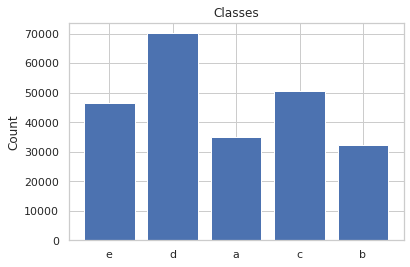

In [168]:
from collections import Counter

distribution = Counter(y_train)
plt.bar(distribution.keys(), distribution.values());

plt.ylabel('Count')
plt.title('Classes')
 
plt.show()

Print the 10 most common ingredients

In [174]:
ingredients_tags = X_train[X_train['ingredients_tags'].notnull()]
ingredients_tags = ingredients_tags['ingredients_tags']

unique_ingredients_tags = []
nb_ingredients_distribution = []

for ing in ingredients_tags:
    ing_list = ing.split(',')
    unique_ingredients_tags += ing_list
    nb_ingredients_distribution.append(len(ing_list))
    
mean_number_of_ingredients = len(unique_ingredients_tags)/X_train.shape[0]

unique_ingredients_tags = [i.replace(' ', '') for i in unique_ingredients_tags]
unique_ingredients_tags = Counter(unique_ingredients_tags)

unique_ingredients_tags.most_common(10)

[('en:salt', 84512),
 ('en:sugar', 71480),
 ('en:water', 58923),
 ('en:oil-and-fat', 56757),
 ('en:flavouring', 52065),
 ('en:dairy', 51405),
 ('en:vegetable-oil-and-fat', 51142),
 ('en:cereal', 43503),
 ('en:vegetable', 43451),
 ('en:wheat', 37095)]

In [175]:
print("Mean number of ingredients =", mean_number_of_ingredients)

Mean number of ingredients = 14.043226153294762


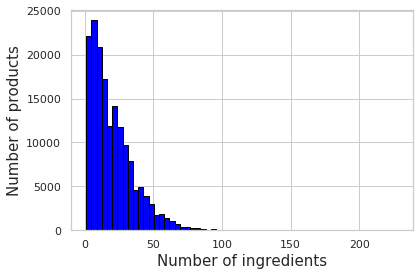

In [177]:
plt.hist(nb_ingredients_distribution, bins = int(60), color = 'blue', edgecolor = 'black')
plt.xlabel('Number of ingredients', size = 15)
plt.ylabel('Number of products', size= 15)
plt.tight_layout()
plt.show()

As it is shown on the graph below, there is an important number of ingredients that appear only very few times.

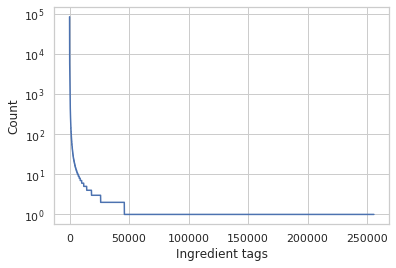

In [129]:
y = sorted(list(unique_ingredients_tags.values()), reverse=True)
x = np.arange(len(y))
plt.yscale("log")
plt.plot(x,y)
plt.xlabel("Ingredient tags")
plt.ylabel("Count")
plt.show()


# 3. Model to submit
## 3.1. Workflow

The model works as follows :
* A feature extractor is used on the input to perform feature engineering
* The features generated are fed to a model to generate a prediction

<p> During the training, the model will use the labels to correct its behaviour. <br> Then, the model is evaluated over a test set using our metric. </p>

<img src="resources/workflow.png" width="800">

## 3.2. Feature Extractor

In [6]:
%%file submissions/starting_kit/feature_extractor.py

class FeatureExtractor:
    def __init__(self):
        
    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):
        #TODO

Overwriting submissions/starting_kit/feature_extractor.py


## 3.3. Baseline Classifier

In [7]:
%%file submissions/starting_kit/classifier.py
from sklearn.tree import DecisionTree

class Classifier(BaseEstimator):
    
    def __init__(self):
        self.model = DecisionTree()
        
    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)

Overwriting submissions/starting_kit/classifier.py


# 4. Submitting on RAMP
You can test locally your submission before sending it to the RAMP platform backend using the command !ramp_test_submission --submission starting_kit.

The usual way to use this is to explore various models, feature transformations, hyper-parameters optimization and test them using the following command. It uses our metric to estimate your score.

To test files stored in a different folder, just replace 'starting_kit' by the name of your folder

In [ ]:
!ramp_test_submission --submission starting_kit